# Task 1 Overfit with the Smallest Possible Model
5390<br>
Elaina Rohlfing


## Load the data
* Upload & unzip the dataset
* Load training and validation images
* Combine images into single folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! rm -rf morel-dataset
! unzip -qq "/content/drive/MyDrive/Colab Notebooks/morel-dataset.zip"
! mv morel-dataset* morel-dataset

In [ ]:
! mkdir /content/morel-dataset/overfit
! mkdir /content/morel-dataset/overfit/morel
! mkdir /content/morel-dataset/overfit/none
! mv /content/morel-dataset/train/morel/* /content/morel-dataset/overfit/morel/
! mv /content/morel-dataset/train/none/*  /content/morel-dataset/overfit/none/
! mv /content/morel-dataset/validation/morel/* /content/morel-dataset/overfit/morel/
! mv /content/morel-dataset/validation/none/*  /content/morel-dataset/overfit/none/
#! mv /content/morel-dataset/test/morel/* /content/morel-dataset/overfit/morel/
#! mv /content/morel-dataset/test/none/*  /content/morel-dataset/overfit/none/
! ls -l /content/morel-dataset/overfit/morel | wc -l
! ls -l /content/morel-dataset/overfit/none | wc -l

357
357


## Prepare the images (training and validation)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescale all images by 1./255
my_generator = ImageDataGenerator(rescale=1./255)

image_size = (256, 256)
batch = 32
# Generator for training dataset
train_set = my_generator.flow_from_directory( "./morel-dataset/overfit", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=batch)

Found 712 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Review details of dataset
def print_data_deets(data):
    print(f'{data.class_indices=}')
    print(f'{data.num_classes=}')
    print(f'{data.batch_size=}')
    print(f'{data.samples=}')
    print(f'{data.image_shape=}')
    imgs, lbls = data[0]
    print(f'{lbls.shape=}')
    print(f'{lbls=}')

    # check baseline accurracy (for majority class in binary classification)
    num_class0 = data.classes[data.classes == 0].size
    num_class1 = data.classes[data.classes == 1].size
    class1_relative_size = (100 * (num_class1/(num_class0 + num_class1)))
    class0_relative_size = (100 - class1_relative_size)
    if class1_relative_size > class0_relative_size:
        print(f'\nMajority class is class[1]\nBaseline accuracy for this dataset is: {class1_relative_size:.2f}%')
    else:
        print(f'\nMajority class is class[0]\nBaseline accuracy for this dataset is: {class0_relative_size:.2f}%')

# Takes one batch full of images
def display_image(dataset, img_index=0, batch_index=0):
    images, labels = dataset[batch_index]
    class_index = int(labels[img_index])
    classes = list(dataset.class_indices.keys())

    plt.imshow(images[img_index])
    plt.title(f"{str(labels[img_index])} {classes[class_index]}") # add name of label train_ds.class_indices
    plt.axis("off")

Display one image and its label

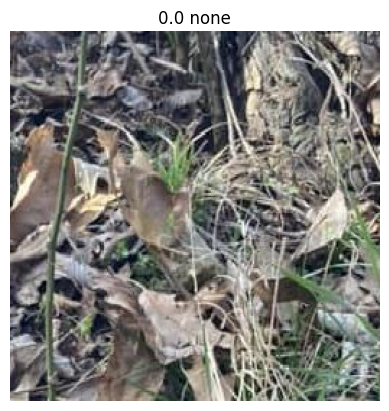

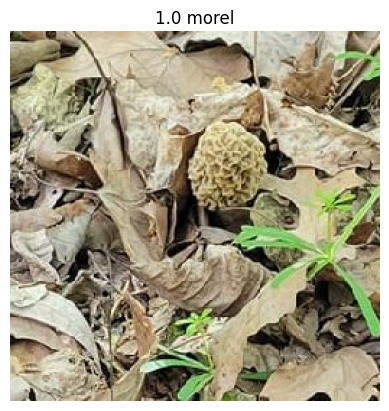

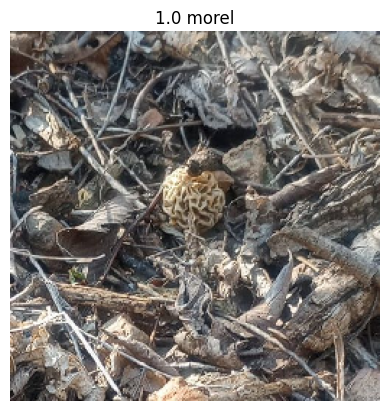

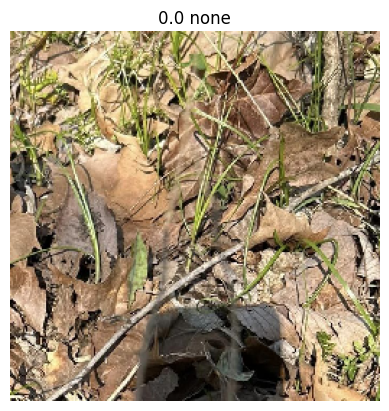

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=32
data.samples=712
data.image_shape=(256, 256, 3)
lbls.shape=(32,)
lbls=array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [ ]:
for i in range(0, 32, 9):
    display_image(train_set, i, 1)
    plt.show()
print_data_deets(train_set)

# Function to plot learning curves

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curves(hist, title, validate=False):
    fig, axs = plt.subplots(2, 1, figsize=(6, 7))
    epochs = range(1, len(hist.history['loss']) + 1)

    if validate:
        axs[0].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
    axs[0].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    axs[0].set_title("Accuracy for " + title)
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    if validate:
        axs[1].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    axs[1].plot(epochs, hist.history['loss'], label='Training Loss')
    axs[1].set_title("Loss for " + title)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# 1. Build the smallest possible model ("model")
Smallest is defined as least parameters needed to achieve our goal of overfitting. Be careful, parameters should be concentrated in convolutional layers, not the dense layers.

In [ ]:
from tensorflow.keras import datasets, layers, models

# Decreasing filters 16,8,4 -> :|
# 7K params: In about 60 epochs, with batch size 128, this overfits with 100% accuracy
def model_too_large():
    num_filters = [16, 8, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (4, 4)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;



# Increasing filters 4,6,6 -> :)
# 1155 params: In about 200 epochs, with batch size 128, this model's accuracy is 96%
def model_large():
    num_filters = [4, 6, 6]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# BEST Decreasing filters 6,6,4 -> :)
# 1049 params: In about 200 epochs, with batch size 128, this model's accuracy is 96%
def model_large_reverse():
    num_filters = [6, 6, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Increasing filters 2,4,6 # DONE -> :(
# 649 params: In about 130 epochs, with batch size 128, this model's accuracy is 80%
# 649 params: In about 98 more epochs, with batch size 128, this model's accuracy is only 86%
def model_small():
    num_filters = [2, 4, 6]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    #model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    #model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# Decreasing filters 6,4,2 -> :|
# 565 Params: in about 175 epochs, with batch size 128, this model's accuracy is 86%
# 565 Params: in 100 more epochs, with batch size 128, this model's accuracy is 90%
def model_small_reverse():
    num_filters = [6, 4, 2]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    #model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    #model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

# uniform filters 4,4,4 - DONE -> :(
# 607 params: In about 200 epochs, with batch size 128, this model's accuracy is 86% - Struggling to go higher
def model_medium():
    num_filters = [4, 4, 4]
    filter_shape = (3, 3)
    inputshape = train_set.image_shape
    pad = 'same'
    pool = (8, 8)
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters[0], kernel_size=filter_shape, activation='relu', padding=pad, input_shape=inputshape, name="first_layer_conv"))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad, name="first_layer_pool"))
    model.add(layers.Conv2D(num_filters[1], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    model.add(layers.Conv2D(num_filters[2], kernel_size=filter_shape, activation='relu', padding=pad))
    #model.add(layers.MaxPooling2D(pool_size=pool, padding=pad))
    #model.add(layers.Conv2D(num_filters[3], kernel_size=filter_shape, activation='relu', padding=pad))
    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

## Inspect the model

In [ ]:
# trained with new dataset: yes
stop
#model4 = model_small_reverse()
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 6)       168       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 4)         220       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 4, 4, 4)           0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 2)           74        
                                                                 
 flatten_9 (Flatten)         (None, 32)               

In [ ]:
# trained with new dataset: Yes
stop
#model3 = model_medium()
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 4)       112       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 4)         148       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 4, 4, 4)           0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 4)           148       
                                                                 
 flatten_11 (Flatten)        (None, 64)              

In [ ]:
# run with new data: yes
stop
#model2 = model_small()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 2)       56        
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 2)         0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 4)         76        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 4)           0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 6)           222       
                                                                 
 flatten_2 (Flatten)         (None, 96)               

In [ ]:
# run with new data: yes
stop
#model5 = model_too_large()
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer_conv (Conv2D)   (None, 256, 256, 16)      448       
                                                                 
 first_layer_pool (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 4)         292       
                                                                 
 flatten_4 (Flatten)         (None, 1024)             

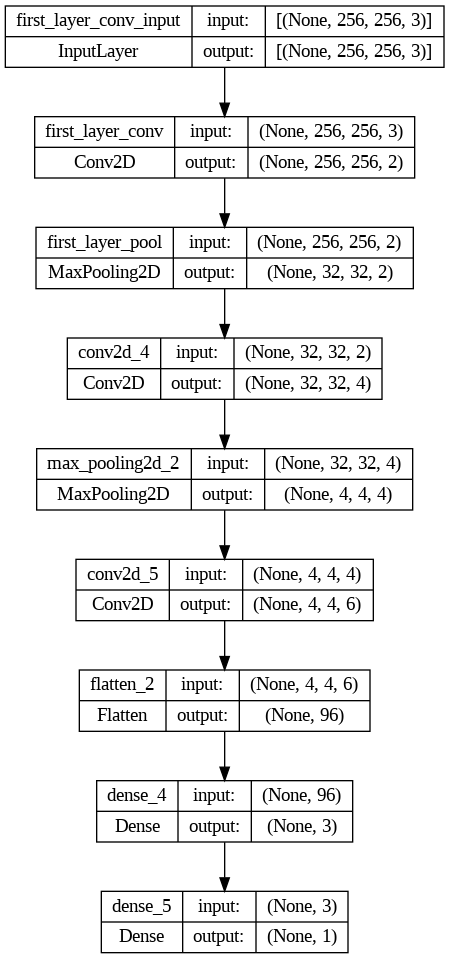

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, show_layer_names=True, show_shapes=True)

## Add a callback for early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# general callback for all models
cb_stopping = EarlyStopping(monitor="accuracy", patience=25)

## Compile the model [7031 params] to check for errors & Train
* Epoch 71/200 5s 212ms/step - loss: 0.0051 - accuracy: 1.0000



### Train

In [ ]:
stop

In [ ]:
#model5.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history5 = model5.fit(train_set, epochs=200, verbose=1, batch_size=128)

Epoch 1/200
23/23 [==============================] - 7s 223ms/step - loss: 0.6954 - accuracy: 0.4705
Epoch 2/200
23/23 [==============================] - 4s 188ms/step - loss: 0.6881 - accuracy: 0.5492
Epoch 3/200
23/23 [==============================] - 4s 181ms/step - loss: 0.6811 - accuracy: 0.6053
Epoch 4/200
23/23 [==============================] - 6s 234ms/step - loss: 0.6541 - accuracy: 0.6264
Epoch 5/200
23/23 [==============================] - 4s 177ms/step - loss: 0.6312 - accuracy: 0.6489
Epoch 6/200
23/23 [==============================] - 5s 210ms/step - loss: 0.6189 - accuracy: 0.6545
Epoch 7/200
23/23 [==============================] - 5s 205ms/step - loss: 0.6172 - accuracy: 0.6671
Epoch 8/200
23/23 [==============================] - 4s 183ms/step - loss: 0.6048 - accuracy: 0.7177
Epoch 9/200
23/23 [==============================] - 5s 230ms/step - loss: 0.5924 - accuracy: 0.7037
Epoch 10/200
23/23 [==============================] - 5s 201ms/step - loss: 0.5760 - accura

KeyboardInterrupt: 

In [ ]:
model5.evaluate(train_set)

## Compile the model1 [1155 params] to check for errors & Train
* Epoch 200/200 5s 227ms/step - loss: 0.1487 - accuracy: 0.9537

### Train

In [ ]:
stop

In [ ]:
# run with new data: yes
stop
#model1 = model_large()
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 4)       112       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 6)         222       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 4, 4, 6)           0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 6)           330       
                                                                 
 flatten_7 (Flatten)         (None, 96)               

In [ ]:
stop

In [ ]:
#model1.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history1 = model1.fit(train_set, epochs=200, verbose=1, batch_size=128)

Epoch 1/200
23/23 [==============================] - 7s 164ms/step - loss: 0.6956 - accuracy: 0.4930
Epoch 2/200
23/23 [==============================] - 4s 184ms/step - loss: 0.6907 - accuracy: 0.5351
Epoch 3/200
23/23 [==============================] - 5s 229ms/step - loss: 0.6878 - accuracy: 0.5407
Epoch 4/200
23/23 [==============================] - 4s 179ms/step - loss: 0.6850 - accuracy: 0.5590
Epoch 5/200
23/23 [==============================] - 4s 181ms/step - loss: 0.6834 - accuracy: 0.5716
Epoch 6/200
23/23 [==============================] - 5s 234ms/step - loss: 0.6787 - accuracy: 0.6025
Epoch 7/200
23/23 [==============================] - 4s 186ms/step - loss: 0.6732 - accuracy: 0.6320
Epoch 8/200
23/23 [==============================] - 4s 184ms/step - loss: 0.6663 - accuracy: 0.6390
Epoch 9/200
23/23 [==============================] - 5s 229ms/step - loss: 0.6584 - accuracy: 0.6419
Epoch 10/200
23/23 [==============================] - 4s 190ms/step - loss: 0.6538 - accura

### Review

In [ ]:
stop

In [ ]:
model1.evaluate(train_set)

23/23 [==============================] - 6s 238ms/step - loss: 0.1643 - accuracy: 0.9466


[0.16431966423988342, 0.9466292262077332]

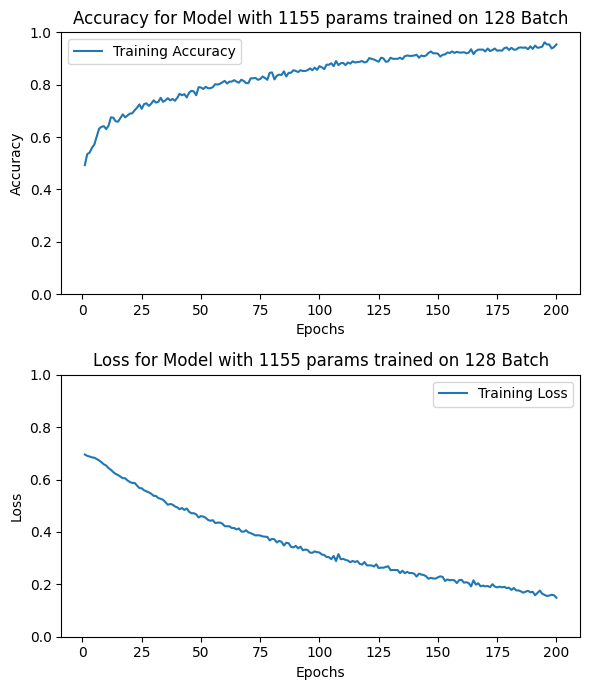

In [ ]:
#Model large [4,6,6]
plot_learning_curves(history1, "Model with 1155 params trained on 128 Batch")

## Compile the model6 [1049 params] to check for errors & Train
* Epoch 200/200 4s 173ms/step - loss: 0.1700 - accuracy: 0.9565

### Train

In [ ]:
stop

In [ ]:
# trained with new dataset: yes
stop
#model6 = model_large_reverse()
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 6)       168       
                                                                 
 first_layer_pool (MaxPooli  (None, 32, 32, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 6)         330       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 6)           0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 4)           220       
                                                                 
 flatten (Flatten)           (None, 64)                0

In [ ]:
#model6.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history6 = model6.fit(train_set, epochs=200, verbose=1, callbacks=cb_stopping, batch_size=128)

Epoch 1/200
23/23 [==============================] - 7s 157ms/step - loss: 0.6933 - accuracy: 0.5140
Epoch 2/200
23/23 [==============================] - 4s 173ms/step - loss: 0.6913 - accuracy: 0.5407
Epoch 3/200
23/23 [==============================] - 4s 177ms/step - loss: 0.6901 - accuracy: 0.5492
Epoch 4/200
23/23 [==============================] - 4s 176ms/step - loss: 0.6882 - accuracy: 0.5435
Epoch 5/200
23/23 [==============================] - 4s 169ms/step - loss: 0.6878 - accuracy: 0.5506
Epoch 6/200
23/23 [==============================] - 4s 176ms/step - loss: 0.6859 - accuracy: 0.5435
Epoch 7/200
23/23 [==============================] - 4s 171ms/step - loss: 0.6833 - accuracy: 0.5674
Epoch 8/200
23/23 [==============================] - 4s 171ms/step - loss: 0.6813 - accuracy: 0.5815
Epoch 9/200
23/23 [==============================] - 4s 173ms/step - loss: 0.6816 - accuracy: 0.5660
Epoch 10/200
23/23 [==============================] - 4s 174ms/step - loss: 0.6790 - accura

### Review

In [ ]:
stop

23/23 [==============================] - 4s 170ms/step - loss: 0.1877 - accuracy: 0.9466


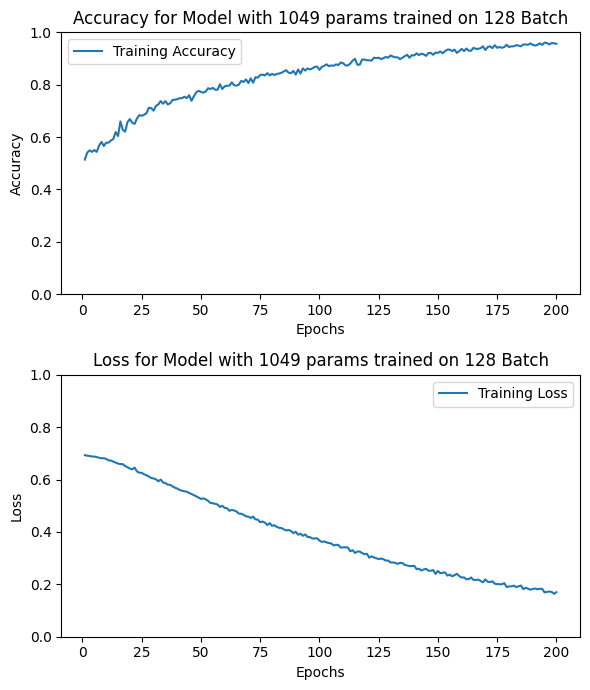

In [ ]:
# Model large_reverse 6,6,4
model6.evaluate(train_set)
plot_learning_curves(history6, "Model with 1049 params trained on 128 Batch")

## Compile the model2 [649 params] to check for errors & Train
* Epoch 124/200 5s 220ms/step - loss: 0.4570 - accuracy: 0.8062
* Epoch 98/100 4s 182ms/step - loss: 0.3428 - accuracy: 0.8553

### Train

In [ ]:
stop

In [ ]:
#model2.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history2 = model2.fit(train_set, epochs=200, verbose=1, callbacks=cb_stopping,  batch_size=128)

Epoch 1/200
23/23 [==============================] - 9s 209ms/step - loss: 0.6965 - accuracy: 0.5000
Epoch 2/200
23/23 [==============================] - 5s 204ms/step - loss: 0.6912 - accuracy: 0.5197
Epoch 3/200
23/23 [==============================] - 4s 176ms/step - loss: 0.6903 - accuracy: 0.5267
Epoch 4/200
23/23 [==============================] - 5s 236ms/step - loss: 0.6894 - accuracy: 0.5801
Epoch 5/200
23/23 [==============================] - 4s 183ms/step - loss: 0.6876 - accuracy: 0.5969
Epoch 6/200
23/23 [==============================] - 5s 235ms/step - loss: 0.6855 - accuracy: 0.5955
Epoch 7/200
23/23 [==============================] - 4s 174ms/step - loss: 0.6834 - accuracy: 0.5899
Epoch 8/200
23/23 [==============================] - 4s 179ms/step - loss: 0.6824 - accuracy: 0.5660
Epoch 9/200
23/23 [==============================] - 5s 234ms/step - loss: 0.6790 - accuracy: 0.6166
Epoch 10/200
23/23 [==============================] - 4s 172ms/step - loss: 0.6746 - accura

In [ ]:
history2a = model2.fit(train_set, epochs=100, verbose=1, callbacks=cb_stopping,  batch_size=128)

Epoch 1/100
23/23 [==============================] - 4s 191ms/step - loss: 0.4496 - accuracy: 0.8006
Epoch 2/100
23/23 [==============================] - 5s 218ms/step - loss: 0.4483 - accuracy: 0.8090
Epoch 3/100
23/23 [==============================] - 6s 253ms/step - loss: 0.4475 - accuracy: 0.8090
Epoch 4/100
23/23 [==============================] - 5s 208ms/step - loss: 0.4439 - accuracy: 0.8104
Epoch 5/100
23/23 [==============================] - 6s 262ms/step - loss: 0.4451 - accuracy: 0.8048
Epoch 6/100
23/23 [==============================] - 5s 233ms/step - loss: 0.4435 - accuracy: 0.8062
Epoch 7/100
23/23 [==============================] - 6s 276ms/step - loss: 0.4407 - accuracy: 0.8104
Epoch 8/100
23/23 [==============================] - 4s 177ms/step - loss: 0.4431 - accuracy: 0.8062
Epoch 9/100
23/23 [==============================] - 4s 176ms/step - loss: 0.4414 - accuracy: 0.8090
Epoch 10/100
23/23 [==============================] - 5s 237ms/step - loss: 0.4432 - accura

### Review

In [ ]:
stop

In [ ]:
print("Train for 100 more epochs.")
model2.evaluate(train_set)
plot_learning_curves(history2, "Model with 649 Params, Trained on Batch 128")

23/23 [==============================] - 5s 225ms/step - loss: 0.4522 - accuracy: 0.7949


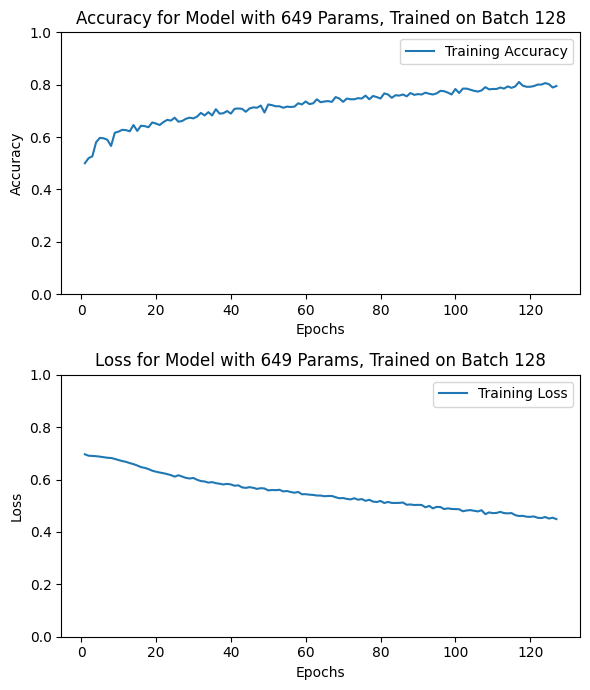

In [ ]:
model2.evaluate(train_set)
plot_learning_curves(history2, "Model with 649 Params, Trained on Batch 128")

## Compile the model3 [607 params] to check for errors & Train
* Epoch 200/200 4s 183ms/step - loss: 0.3247 - accuracy: 0.8567

### Train

In [ ]:
stop

In [ ]:
#model3.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history3 = model3.fit(train_set, epochs=200, callbacks=cb_stopping, batch_size=128)

Epoch 1/200
23/23 [==============================] - 6s 183ms/step - loss: 0.6928 - accuracy: 0.5042
Epoch 2/200
23/23 [==============================] - 4s 183ms/step - loss: 0.6897 - accuracy: 0.5379
Epoch 3/200
23/23 [==============================] - 5s 236ms/step - loss: 0.6846 - accuracy: 0.5590
Epoch 4/200
23/23 [==============================] - 4s 181ms/step - loss: 0.6804 - accuracy: 0.5941
Epoch 5/200
23/23 [==============================] - 5s 231ms/step - loss: 0.6763 - accuracy: 0.6053
Epoch 6/200
23/23 [==============================] - 4s 177ms/step - loss: 0.6673 - accuracy: 0.6166
Epoch 7/200
23/23 [==============================] - 4s 192ms/step - loss: 0.6644 - accuracy: 0.6039
Epoch 8/200
23/23 [==============================] - 5s 226ms/step - loss: 0.6588 - accuracy: 0.6292
Epoch 9/200
23/23 [==============================] - 4s 181ms/step - loss: 0.6565 - accuracy: 0.6194
Epoch 10/200
23/23 [==============================] - 4s 175ms/step - loss: 0.6512 - accura

### Review

In [ ]:
stop

23/23 [==============================] - 4s 174ms/step - loss: 0.3031 - accuracy: 0.8862


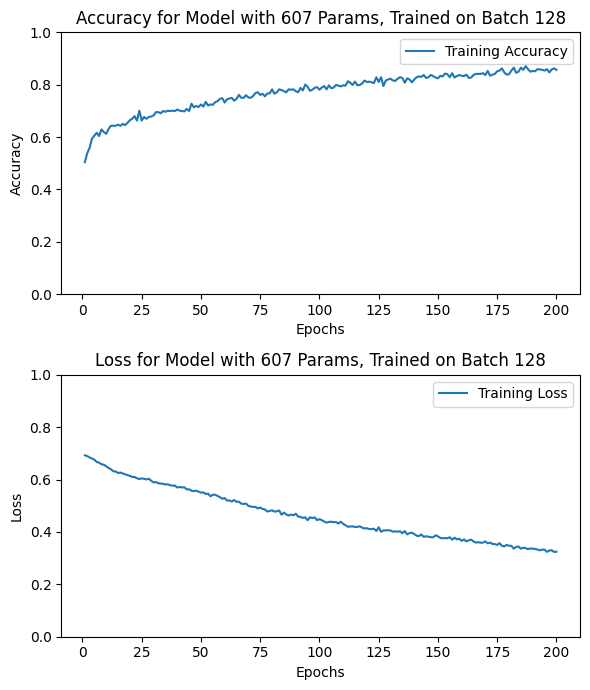

In [ ]:
model3.evaluate(train_set)
plot_learning_curves(history3, "Model with 607 Params, Trained on Batch 128")

## Compile the model4 [565  params] to check for errors & Train
* Epoch 175/200 6s 243ms/step - loss: 0.3750 - accuracy: 0.8567
* Epoch 100/100 4s 193ms/step - loss: 0.2743 - accuracy: 0.9031

### Train

In [ ]:
stop

In [ ]:
#model4.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
#history4 = model4.fit(train_set, epochs=200, callbacks=cb_stopping, batch_size=128)

Epoch 1/200
23/23 [==============================] - 6s 164ms/step - loss: 0.6949 - accuracy: 0.5169
Epoch 2/200
23/23 [==============================] - 4s 174ms/step - loss: 0.6940 - accuracy: 0.4986
Epoch 3/200
23/23 [==============================] - 6s 256ms/step - loss: 0.6926 - accuracy: 0.5140
Epoch 4/200
23/23 [==============================] - 4s 177ms/step - loss: 0.6928 - accuracy: 0.5014
Epoch 5/200
23/23 [==============================] - 4s 177ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 6/200
23/23 [==============================] - 6s 249ms/step - loss: 0.6924 - accuracy: 0.5183
Epoch 7/200
23/23 [==============================] - 4s 170ms/step - loss: 0.6931 - accuracy: 0.5042
Epoch 8/200
23/23 [==============================] - 4s 180ms/step - loss: 0.6920 - accuracy: 0.5183
Epoch 9/200
23/23 [==============================] - 5s 202ms/step - loss: 0.6909 - accuracy: 0.5154
Epoch 10/200
23/23 [==============================] - 4s 175ms/step - loss: 0.6905 - accura

In [ ]:
# 100 more epochs without early stopping
#history4a = model4.fit(train_set, epochs=100, batch_size=128)

Epoch 1/100
23/23 [==============================] - 4s 180ms/step - loss: 0.3707 - accuracy: 0.8624
Epoch 2/100
23/23 [==============================] - 5s 195ms/step - loss: 0.3687 - accuracy: 0.8567
Epoch 3/100
23/23 [==============================] - 7s 302ms/step - loss: 0.3702 - accuracy: 0.8638
Epoch 4/100
23/23 [==============================] - 4s 169ms/step - loss: 0.3692 - accuracy: 0.8596
Epoch 5/100
23/23 [==============================] - 5s 217ms/step - loss: 0.3663 - accuracy: 0.8666
Epoch 6/100
23/23 [==============================] - 6s 241ms/step - loss: 0.3668 - accuracy: 0.8610
Epoch 7/100
23/23 [==============================] - 4s 193ms/step - loss: 0.3655 - accuracy: 0.8567
Epoch 8/100
23/23 [==============================] - 7s 306ms/step - loss: 0.3664 - accuracy: 0.8553
Epoch 9/100
23/23 [==============================] - 6s 237ms/step - loss: 0.3597 - accuracy: 0.8638
Epoch 10/100
23/23 [==============================] - 9s 402ms/step - loss: 0.3586 - accura

### Review

In [ ]:
stop

23/23 [==============================] - 5s 206ms/step - loss: 0.3599 - accuracy: 0.8680


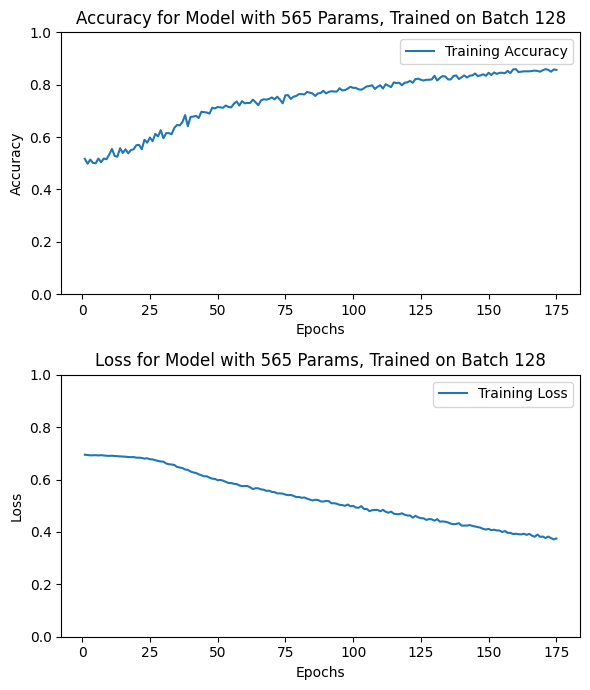

In [ ]:
model4.evaluate(train_set)
plot_learning_curves(history4, "Model with 565 Params, Trained on Batch 128")

100 more epochs without early stopping
23/23 [==============================] - 5s 237ms/step - loss: 0.2527 - accuracy: 0.9199


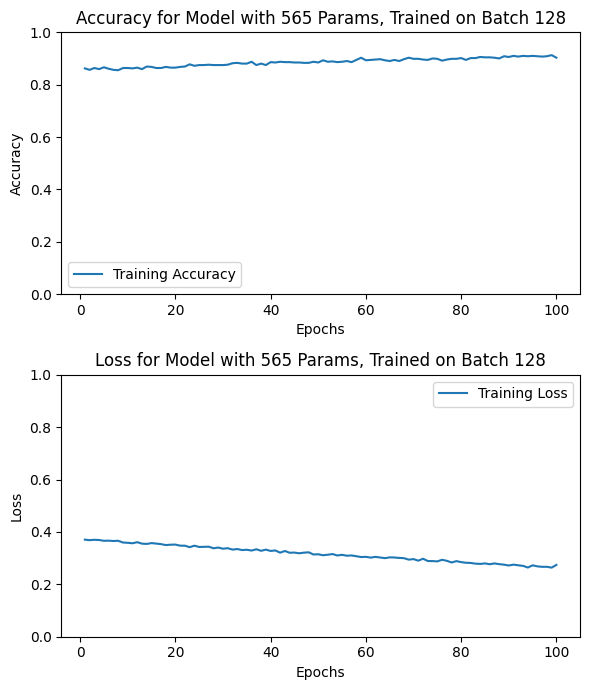

In [ ]:
print("100 more epochs without early stopping")
model4.evaluate(train_set)
plot_learning_curves(history4a, "Model with 565 Params, Trained on Batch 128")